<center>

# **如何进行GLM 二阶分析**

</center>

***

基于volume空间的 GLM二阶分析代码，以 NARPS 数据集中的被试数据为例进行演示。

本教程展示了如何在大脑皮层表面空间中进行fMRI数据的一阶GLM分析。

**参考资料：**
- [NARPS数据集描述](https://www.nature.com/articles/s41586-020-2314-9)

In [10]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
from brainstat.stats.terms import FixedEffect, MixedEffect
from brainstat.stats.SLM import SLM
from typing import List, Dict, Union, Optional, Sequence
from numpy.typing import ArrayLike
import warnings
warnings.filterwarnings('ignore')


In [18]:
# 设置路径
data_dir = Path("/Volumes/ss/derivatives/first_level_model_corrected_nii")

output_dir = r"/Volumes/ss/derivatives/second_level_results_corrected_nii"

In [13]:
# 设置实验条件
condition = "accept"
if condition == "accept":
    conditions = ["strongly_accept", "weakly_accept"]
elif condition == "reject":
    conditions = ["strongly_reject", "weakly_reject"]

In [25]:
subject_dirs = [d for d in data_dir.iterdir()
                if d.is_dir() and d.name.startswith('sub-')]

subjects_list = []
data_list = []

# 这里只示例前10个被试
for sub_dir in subject_dirs[:40]:  
    # 以被试ID命名的 文件夹，例如 "sub-001"
    sub_id = sub_dir.name
    # 如果你用的是自己的数据，请改为自己的文件夹命名
    stats_dir = sub_dir / "stats_results"
    
    if not stats_dir.exists():
        print(f"跳过 {sub_id}, 没有 stats_results 文件夹")
        continue

    # 存放每个被试的两个条件数据
    condition_maps = []
    for cond in conditions:
        run_maps = []
        for run in range(1, 5):  # 如果你要用自己的数据，可以更改，目前的是"4 个 run"
            file_path = stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_{cond}_zmap.nii.gz" # 这里根据自己的数据和实际路径修改
            if file_path.exists():
                img = nib.load(file_path)
                run_maps.append(img.get_fdata())
            else:
                print(f"{file_path} 不存在，跳过该 run")

        if run_maps:
            condition_maps.append(np.mean(run_maps, axis=0))

    # 如果两个条件都有，取平均
    if len(condition_maps) == 2:
        avg_map = np.mean(condition_maps, axis=0)
        data_list.append(avg_map)
        subjects_list.append(sub_id)

print(f"成功加载 {len(subjects_list)} 个被试的数据，形状: {data_list[0].shape}")

/Volumes/ss/derivatives/first_level_model_corrected_nii/sub-003/stats_results/run-03/sub-003_task-MGT_run-03_weakly_accept_zmap.nii.gz 不存在，跳过该 run
/Volumes/ss/derivatives/first_level_model_corrected_nii/sub-003/stats_results/run-04/sub-003_task-MGT_run-04_weakly_accept_zmap.nii.gz 不存在，跳过该 run
/Volumes/ss/derivatives/first_level_model_corrected_nii/sub-013/stats_results/run-02/sub-013_task-MGT_run-02_weakly_accept_zmap.nii.gz 不存在，跳过该 run
/Volumes/ss/derivatives/first_level_model_corrected_nii/sub-013/stats_results/run-04/sub-013_task-MGT_run-04_weakly_accept_zmap.nii.gz 不存在，跳过该 run
成功加载 40 个被试的数据，形状: (97, 115, 81)


In [20]:
data = np.array([d.ravel() for d in data_list])  
n_subjects, n_voxels = data.shape
print(f"数据矩阵形状: {data.shape}")

数据矩阵形状: (10, 903555)


In [21]:
# 截距项（单样本 t 检验 = 检验均值是否 ≠ 0）
intercept = FixedEffect(np.ones(n_subjects))
contrast = np.ones(n_subjects).astype(int)

In [22]:
mask_img = data_importer.create_mask_image()
slm = SLM(
    model=intercept,
    contrast=contrast,
    surf=mask_img,
    correction=['fdr'],
    cluster_threshold=0.001,
    two_tailed=True
)
slm.fit(data)

创建分析掩膜...
掩膜包含 175848 个体素


In [23]:
t_map = slm.t.reshape(data_list[0].shape)
t_img = nib.Nifti1Image(t_map, affine=mask_img.affine)
nib.save(t_img, output_dir / f"{condition}_tstat.nii.gz")
print("结果已保存！")

TypeError: unsupported operand type(s) for /: 'str' and 'str'

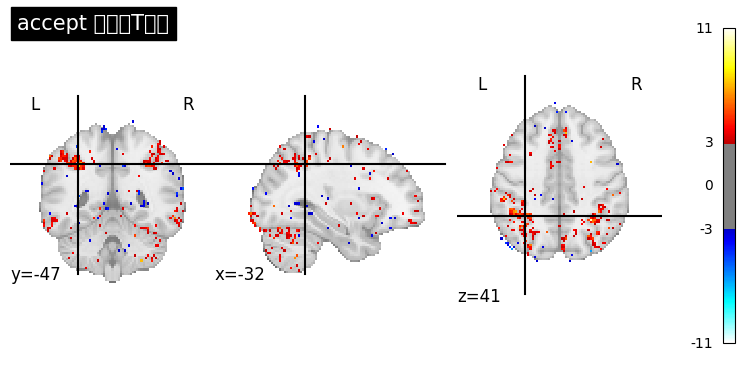

In [24]:
plotting.plot_stat_map(t_img, title=f"{condition} 单样本T检验", threshold=3.0)
plotting.show()

In [2]:

# ------------------------------
# 1. 数据导入模块
# ------------------------------
class DataImporter:
    """
    数据导入模块，用于加载fMRI数据并生成DataFrame.
    """
    def __init__(self, data_dir: str):
        """
        初始化数据导入器。

        Parameters:
        -----------
        data_dir : str
            数据根目录的路径。
        """
        self.data_dir = Path(data_dir)
        self.subjects: List[str] = []
        self.data: Dict[str, List[np.ndarray]] = {
            'strongly_accept': [],
            'strongly_reject': [],
            'weakly_accept': [],
            'weakly_reject': []
        }
        self.data_df: Optional[pd.DataFrame] = None  # 用于存储数据的DataFrame
        self.original_shape = None
        self.file_paths: Dict[str, Dict[str, List[Path]]] = {
            'strongly_accept': {},
            'strongly_reject': {},
            'weakly_accept': {},
            'weakly_reject': {}
        }  # 存储文件路径，结构为 condition -> subject -> [path1, path2, ...]

    def load_data(self) -> bool:
        """
        加载fMRI数据，并生成DataFrame.
        """
        print("正在加载数据...")

        # 获取所有被试文件夹
        subject_dirs = [d for d in self.data_dir.iterdir()
                       if d.is_dir() and d.name.startswith('sub-')]

        for sub_dir in sorted(subject_dirs[0:40]):  # 这里仅使用部分被试
            sub_id = sub_dir.name
            stats_dir = sub_dir / 'stats_results'

            if not stats_dir.exists():
                print(f"警告: {sub_id} 缺少stats_results文件夹")
                continue

            # 构建所有条件的文件路径字典，包含run信息
            files = {
                'strongly_accept': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_strongly_accept_zmap.nii.gz" for run in range(1, 5)],
                'strongly_reject': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_strongly_reject_zmap.nii.gz" for run in range(1, 5)],
                'weakly_accept': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_weakly_accept_zmap.nii.gz" for run in range(1, 5)],
                'weakly_reject': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_weakly_reject_zmap.nii.gz" for run in range(1, 5)]
            }

            # 加载每个被试的数据并平均
            try:
                subject_data = {}
                for condition, file_paths in files.items():
                    condition_data = []
                    for file_path in file_paths:
                        if file_path.exists():
                            img = nib.load(file_path)
                            data = img.get_fdata()
                            condition_data.append(data)
                        else:
                            print(f"警告: {sub_id} 缺少文件: {file_path.name}")
                            condition_data.append(np.full(self.original_shape, np.nan))  # 如果文件不存在，用NaN填充

                    # 在每个条件下，对所有run的zmap进行平均
                    condition_data = np.nanmean(np.stack(condition_data), axis=0)
                    subject_data[condition] = condition_data

                # 检查所有条件的数据是否都成功加载
                if all(condition in subject_data for condition in files.keys()):
                    for condition in files.keys():
                         self.data[condition].append(subject_data[condition])
                    self.subjects.append(sub_id)
                    # 存储文件路径
                    for condition, file_paths in files.items():
                         self.file_paths[condition][sub_id] = file_paths
                else:
                     print(f"警告: {sub_id} 缺少某些条件的数据，跳过该被试")

            except Exception as e:
                print(f"错误: 无法加载 {sub_id} 的数据: {e}")
                continue

        print(f"成功加载 {len(self.subjects)} 个被试的数据")

        # 将数据转换为numpy数组 (subjects, voxels)
        for condition in self.data:
            if self.data[condition]:
                stacked_data = np.stack(self.data[condition])
                self.original_shape = stacked_data.shape[1:]  # 保存原始形状
                self.data[condition] = stacked_data.reshape(len(self.subjects), -1)

        # 创建DataFrame
        self.data_df = self._create_dataframe()
        return len(self.subjects) > 0

    def _create_dataframe(self) -> pd.DataFrame:
        """
        创建包含所有数据的DataFrame.
        """
        if not self.subjects or not self.data:
            return None
        data = []
        for sub_idx, sub_id in enumerate(self.subjects):
            for condition in self.data.keys():
                if condition in self.file_paths and sub_id in self.file_paths[condition]: # 检查文件路径是否存在
                    for file_path in self.file_paths[condition][sub_id]:
                        data.append({
                            'subject': sub_id,
                            'condition': condition,
                            'file_path': str(file_path)  # 存储文件路径
                        })
        return pd.DataFrame(data)


    def get_data_for_analysis(self, conditions: List[str]) -> np.ndarray:
        """
        根据条件获取分析所需的数据。
        """
        if self.data_df is None:
            raise ValueError("数据尚未加载或DataFrame未创建.")

        # 初始化一个列表来存储数据， (被试数量, 条件数量, 体素数量)
        all_data = []
        for sub_id in self.subjects:
            # 检查被试是否存在于DataFrame中
            if sub_id in self.data_df['subject'].values:
                # 初始化一个数组来存储每个被试的、每个条件的体素数据
                subject_data = []
                for condition in conditions:
                    # 检查条件是否存在于DataFrame中
                    if condition in self.data_df['condition'].values:
                        # 获取数据，如果一个条件没有数据，用NaN填充
                        try:
                            condition_data = self.data[condition][self.subjects.index(sub_id)]
                            subject_data.append(condition_data)
                        except (IndexError, KeyError):
                            print(f"警告: {sub_id} 的 {condition} 数据为空.")
                            subject_data.append(np.full(self.original_shape[0] * self.original_shape[1], np.nan))
                    else:
                        print(f"警告:  条件 {condition} 不存在于 DataFrame.")
                        subject_data.append(np.full(self.original_shape[0] * self.original_shape[1], np.nan))
                # 检查所有条件的数据是否都成功加载
                if not np.isnan(subject_data).all():  # 只要有一个体素不是nan，就说明这个被试的数据是有效的
                    all_data.append(np.stack(subject_data))  # 如果某个被试的数据缺失，则跳过
                else:
                    print(f"警告: {sub_id} 的数据缺失，跳过该被试")
            else:
                print(f"警告: {sub_id} 缺少分析所需的条件的数据")

        # 如果没有被试数据，返回None
        if not all_data:
            return None
        # 返回numpy数组，维度为 (被试数量, 条件数量, 体素数量)
        return np.stack(all_data)


    def create_mask_image(self) -> nib.Nifti1Image:
        """
        根据所有条件的数据，创建分析掩膜的Nifti1Image对象。
        """
        print("创建分析掩膜...")
        # 确保数据已经加载
        if not self.data:
            raise ValueError("请先加载数据.")
        # 将所有条件的数据合并
        all_data = np.concatenate([
            self.data['strongly_accept'],
            self.data['strongly_reject'],
            self.data['weakly_accept'],
            self.data['weakly_reject']
        ], axis=0)
        # 创建掩膜，如果所有被试的该体素数据都不是NaN且不等于0，则为True
        mask = np.int16(np.all(~np.isnan(all_data) & (all_data != 0), axis=0))
        print(f"掩膜包含 {np.sum(mask)} 个体素")

        # 创建 Nifti1Image 对象，使用第一个 condition 的 affine 矩阵。
        # 找到第一个有效文件路径
        first_file_path = None
        for condition in self.file_paths:
            if self.file_paths[condition]:
                for sub_id, paths in self.file_paths[condition].items():
                    if paths:
                         first_file_path = paths[0]
                         break
                if first_file_path:
                    break

        if first_file_path:
            affine = nib.load(first_file_path).affine
            mask_img = nib.Nifti1Image(mask.reshape(self.original_shape), affine)
            return mask_img
        else:
            raise ValueError("无法找到用于创建掩膜的有效文件路径.")

In [3]:
# 设置路径
data_dir = r"/Volumes/ss/derivatives/first_level_model_corrected_nii"
output_dir = r"/Volumes/ss/derivatives/second_level_results_corrected_nii"
# 1. 数据导入, 这里根据自己的数据和实际路径修改数据的导入函数
data_importer = DataImporter(data_dir)
if not data_importer.load_data():
    print("数据加载失败，程序终止。")
# 2. 创建 mask Image
mask_img = data_importer.create_mask_image()

正在加载数据...
警告: sub-003 缺少文件: sub-003_task-MGT_run-01_strongly_reject_zmap.nii.gz
警告: sub-003 缺少文件: sub-003_task-MGT_run-02_strongly_reject_zmap.nii.gz
警告: sub-003 缺少文件: sub-003_task-MGT_run-03_strongly_reject_zmap.nii.gz
警告: sub-003 缺少文件: sub-003_task-MGT_run-04_strongly_reject_zmap.nii.gz
警告: sub-003 缺少文件: sub-003_task-MGT_run-03_weakly_accept_zmap.nii.gz
警告: sub-003 缺少文件: sub-003_task-MGT_run-04_weakly_accept_zmap.nii.gz
错误: 无法加载 sub-003 的数据: all input arrays must have the same shape
警告: sub-011 缺少文件: sub-011_task-MGT_run-02_weakly_reject_zmap.nii.gz
警告: sub-011 缺少文件: sub-011_task-MGT_run-04_weakly_reject_zmap.nii.gz
错误: 无法加载 sub-011 的数据: all input arrays must have the same shape
警告: sub-013 缺少文件: sub-013_task-MGT_run-02_weakly_accept_zmap.nii.gz
警告: sub-013 缺少文件: sub-013_task-MGT_run-04_weakly_accept_zmap.nii.gz
错误: 无法加载 sub-013 的数据: all input arrays must have the same shape
警告: sub-025 缺少文件: sub-025_task-MGT_run-02_weakly_reject_zmap.nii.gz
警告: sub-025 缺少文件: sub-025_task-MGT_run-03_

In [4]:
# ------------------------------
# 2. 单样本T检验模块
# ------------------------------
class OneSampleTTest:
    """
    单样本T检验模块.
    """
    def __init__(self, data_importer: DataImporter, mask_img: nib.Nifti1Image = None):
        """
        初始化单样本T检验器。

        Parameters:
        -----------
        data_importer : DataImporter
            数据导入器对象。
        mask_img : nib.Nifti1Image, optional
            分析的掩膜数据，Nifti1Image对象，用于定义体素， by default None.
        """
        self.data_importer = data_importer
        self.mask_img = mask_img  # 保存mask_img Nifti1Image

    def run_test(self, condition: str) -> SLM:
        """
        运行单样本T检验。

        Parameters:
        -----------
        condition : str
            要分析的条件 ('accept' 或 'reject')。


        Returns:
        --------
        SLM
            BrainStat SLM对象，包含统计结果。
        """
        print(f"\n执行单样本T检验: {condition}")

        if condition == 'accept':
            conditions = ['strongly_accept', 'weakly_accept']
        elif condition == 'reject':
            conditions = ['strongly_reject', 'weakly_reject']
        else:
            raise ValueError("condition 必须是 'accept' 或 'reject'")

        # 获取分析所需的数据,  维度为 (被试数量, 2, 体素数量)
        data = self.data_importer.get_data_for_analysis(conditions)

        # 如果数据获取失败，直接返回None
        if data is None:
            print(f"没有 {condition} 的有效数据，跳过单样本T检验。")
            return None

        # 对 accept 和 reject 计算平均值, (被试数量, 体素数量)
        data = np.mean(data, axis=1)

        # 创建设计矩阵（截距项）
        n_subjects = data.shape[0]  # 修改为获取数据后的被试数量
        intercept = FixedEffect(np.ones(n_subjects))

        # 创建对比向量（测试均值是否显著不同于0）
        contrast = np.ones(n_subjects).astype(int)  # 单样本t检验，对比向量为全1 

        # 创建SLM对象
        slm = SLM(
            model=intercept,
            contrast=contrast,
            surf=self.mask_img,  # 使用 mask_img 作为surf
            correction=['fdr'],
            cluster_threshold=0.001,
            two_tailed=True
        )

        # 拟合模型
        try:
            slm.fit(data)
            print(f"{condition} 单样本T检验完成")
            return slm
        except Exception as e:
            print(f"拟合模型时出错: {e}")
            return None
class ResultSaver:
    """
    结果保存模块.
    """
    def __init__(self, output_dir: str, original_shape: tuple, mask_img: nib.Nifti1Image):
        """
        初始化结果保存器。

        Parameters:
        -----------
        output_dir : str
            输出目录的路径。
        original_shape: tuple
            原始数据的形状
        mask_img : nib.Nifti1Image
            掩膜图像，用于确定输出图像的仿射变换
        """
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.original_shape = original_shape
        self.mask_img = mask_img  # 保存mask_img，用于获取仿射矩阵

    def save_results(self, slm_results: Union[SLM, Dict[str, SLM]], analysis_name: str):
        """
        保存统计结果.

        Parameters:
        -----------
        slm_results : SLM or Dict[str, SLM]
            统计结果 (SLM对象或包含SLM对象的字典)。
        analysis_name : str
            分析的名称，用于命名输出文件。
        """
        if isinstance(slm_results, dict):
            # 多个对比的结果
            for contrast_name, slm in slm_results.items():
                self._save_single_result(slm, f"{analysis_name}_{contrast_name}")
        else:
            # 单个结果
            self._save_single_result(slm_results, analysis_name)

    def _save_single_result(self, slm: SLM, name: str):
        """
        保存单个统计结果.
        """
        try:
            # 保存T统计图
            if hasattr(slm, 't') and slm.t is not None:
                t_map = slm.t.reshape(self.original_shape)
                # 使用mask_img的affine矩阵
                t_img = nib.Nifti1Image(t_map, affine=self.mask_img.affine)
                nib.save(t_img, self.output_dir / f"{name}_tstat.nii.gz")

            # 保存P值图
            if hasattr(slm, 'P') and slm.P is not None:
                p_map = slm.P.reshape(self.original_shape)
                # 使用mask_img的affine矩阵
                p_img = nib.Nifti1Image(p_map, affine=self.mask_img.affine)
                nib.save(p_img, self.output_dir / f"{name}_pstat.nii.gz")

            # 保存校正后的P值图
            if hasattr(slm, 'Q') and slm.Q is not None:
                q_map = slm.Q.reshape(self.original_shape)
                # 使用mask_img的affine矩阵
                q_img = nib.Nifti1Image(q_map, affine=self.mask_img.affine)
                nib.save(q_img, self.output_dir / f"{name}_qstat_fdr.nii.gz")

            print(f"已保存结果: {name}")

        except Exception as e:
            print(f"保存结果时出错 {name}: {e}")

In [5]:
#单样本T检验
result_saver = ResultSaver(output_dir, data_importer.original_shape,mask_img)
one_sample_tester = OneSampleTTest(data_importer,mask_img)
slm_accept = one_sample_tester.run_test('accept')
slm_reject = one_sample_tester.run_test('reject')
result_saver.save_results(slm_accept, 'one_sample_accept')
result_saver.save_results(slm_reject, 'one_sample_accept')


执行单样本T检验: accept
accept 单样本T检验完成

执行单样本T检验: reject
reject 单样本T检验完成
已保存结果: one_sample_accept
已保存结果: one_sample_accept


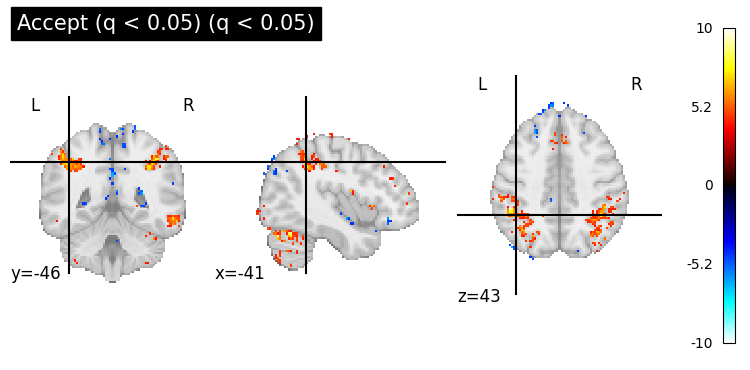

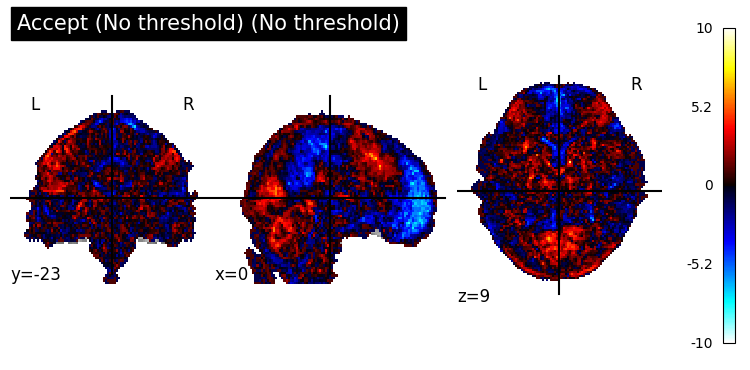

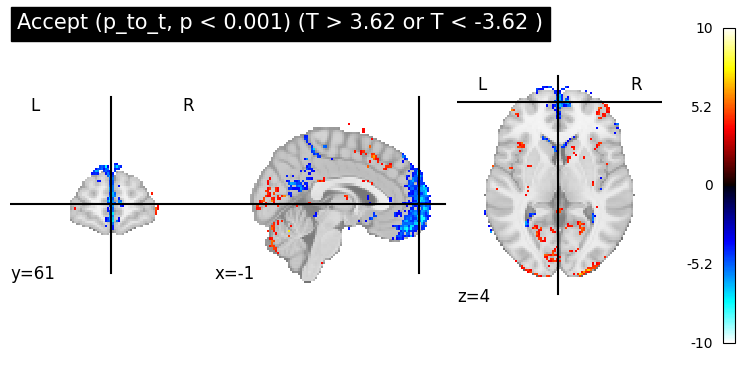

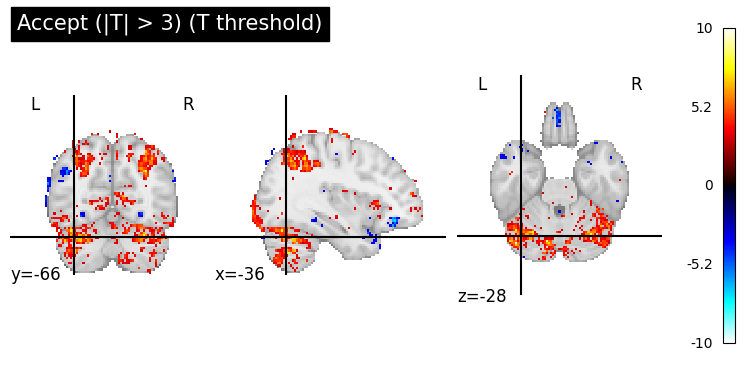

In [ ]:
c

In [7]:
# ------------------------------
# 3. 配对样本T检验模块
# ------------------------------
class PairedTTest:
    """
    配对样本T检验模块.
    """
    def __init__(self, data_importer: DataImporter, mask_img: nib.Nifti1Image):
        """
        初始化配对样本T检验器。

        Parameters:
        -----------
        data_importer : DataImporter
            数据导入器对象。
        mask_img : nib.Nifti1Image
            分析掩膜。
        """
        self.data_importer = data_importer
        self.mask_img = mask_img  # 保存mask_img Nifti1Image

    def run_test(self) -> SLM:
        """
        运行配对样本T检验 (strongly_accept vs strongly_reject).

        Returns:
        --------
        SLM
            BrainStat SLM对象，包含统计结果。
        """
        print("\n执行配对样本t检验: strongly_accept vs strongly_reject")

        conditions = ['strongly_accept', 'strongly_reject']
        data = self.data_importer.get_data_for_analysis(conditions)

        # 如果数据获取失败，直接返回None
        if data is None or data.shape[1] != 2:  # 检查是否成功获取数据，以及是否有两个条件
            print(f"没有 strongly_accept 和 strongly_reject 的有效数据，或数据维度错误，跳过配对T检验。")
            return None

        # 计算差值.  data的维度是 (被试数量, 2, 体素数量), 这里计算差值
        diff_data = data[:, 0, :] - data[:, 1, :]  # 计算 strongly_accept - strongly_reject 的差值

        # 检查计算出的差值数据是否有问题
        if np.all(np.isnan(diff_data)):
            print("差值数据全部为NaN，跳过配对t检验。")
            return None
        
        # 创建设计矩阵（截距项）
        n_subjects = diff_data.shape[0]
        intercept = FixedEffect(np.ones(n_subjects))

        # 创建对比向量  （对比均值是否为0，即配对 t 检验）
        contrast = np.ones(n_subjects).astype(int)  # 配对样本t检验，对比向量为全1，因为已经直接计算好了两个条件的差异 

        # 创建SLM对象
        slm = SLM(
            model=intercept,
            contrast=contrast,
            surf=self.mask_img,  # 使用 mask_img 作为surf
            correction=["fdr"],  # 使用 FDR 校正
            cluster_threshold=0.001,
            two_tailed=True
        )

        # 拟合模型
        try:
            slm.fit(diff_data)
            print("配对样本t检验完成")
            return slm
        except Exception as e:
            print(f"拟合模型时出错: {e}")
            return None


执行配对样本t检验: strongly_accept vs strongly_reject
配对样本t检验完成


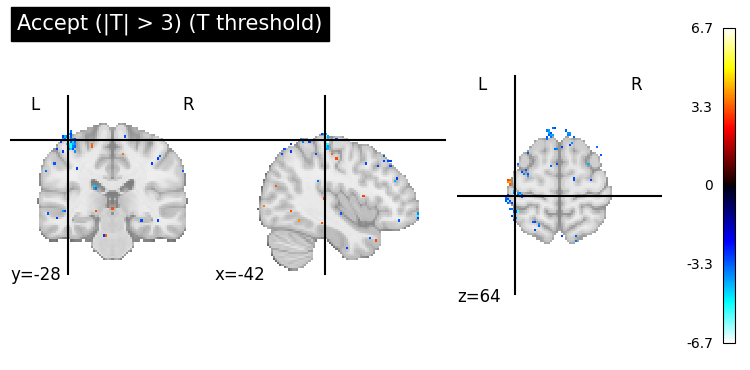

In [211]:
# 创建 PairedTTest 对象
paired_test = PairedTTest(data_importer, mask_img)
# 运行配对 t 检验
slm_paired = paired_test.run_test()
# 使用 T 值阈值（例如，|T| > 3）
visualize_t_map(slm_paired, data_importer.original_shape, mask_img, threshold_type="t", threshold_value=3.0, title="Accept (|T| > 3)")


执行独立样本T检验: accept vs reject
独立样本T检验完成


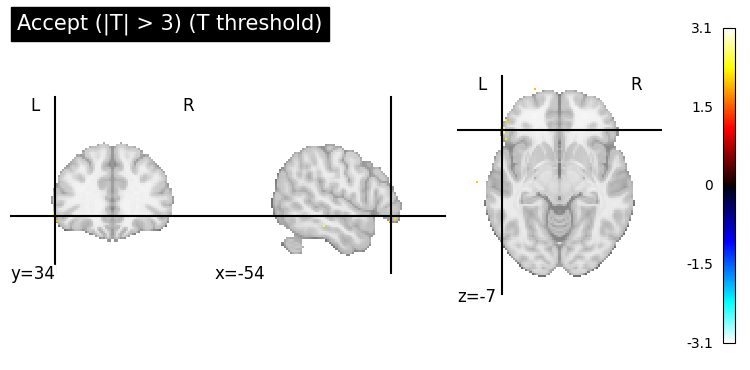

In [8]:
# ------------------------------
# 独立样本T检验
# ------------------------------
# 这里有一个重要的Note，我们的数据并不是两组独立被试，不应该做独立样本T检验，这里只是介绍一些如何做
class Independent_SampleTTest:
    """
    独立样本T检验模块.
    """
    def __init__(self, data_importer: DataImporter, mask_img: nib.Nifti1Image = None):
        """
        初始化独立样本T检验器。

        Parameters:
        -----------
        data_importer : DataImporter
            数据导入器对象。
        mask_img : nib.Nifti1Image, optional
            分析的掩膜数据，Nifti1Image对象，用于定义体素， by default None.
        """
        self.data_importer = data_importer
        self.mask_img = mask_img  # 保存mask_img Nifti1Image

    def run_test(self) -> SLM:
        """
        运行独立样本T检验。

        Returns:
        --------
        SLM
            BrainStat SLM对象，包含统计结果。
        """
        print("\n执行独立样本T检验: accept vs reject")

        conditions = ['strongly_accept', 'weakly_accept', 'strongly_reject', 'weakly_reject']
        data = self.data_importer.get_data_for_analysis(conditions)

        # 如果数据获取失败，直接返回None
        if data is None or data.shape[1] != 4:  # 检查是否成功获取数据, 并且有4个条件
            print(f"没有 accept 和 reject 的有效数据，或数据维度错误，跳过独立样本T检验。")
            return None

        n_subjects = data.shape[0]  # 获取被试数量

        # 计算 accept 和 reject 的平均值
        accept_data = np.mean(data[:, [0, 1], :], axis=1)  # 平均 strongly_accept 和 weakly_accept, (被试数量, 体素数量)
        reject_data = np.mean(data[:, [2, 3], :], axis=1)  # 平均 strongly_reject 和 weakly_reject, (被试数量, 体素数量)

        # 创建长格式数据和对应的 decision 变量
        data_long = np.concatenate([accept_data, reject_data], axis=0)  # 拼接 accept 和 reject 的数据, (2 * 被试数量, 体素数量)
        decision = np.concatenate([np.zeros(n_subjects), np.ones(n_subjects)])  # 0: accept, 1: reject, (2 * 被试数量)
        decision_str = np.array(np.int16(decision), dtype=str)  # 转换为字符串
        # 创建设计矩阵 (使用pandas DataFrame，更易于处理)
        design = pd.DataFrame({
            'decision': decision_str,  # 0: accept, 1: reject
        })
        # 创建固定效应, 使用设计矩阵
        decision_effect = FixedEffect(design[['decision']])
        # 创建对比向量, (reject - accept)
        contrast = (design['decision'] == '1').astype(int) - (design['decision'] == '0').astype(int)
        # 创建SLM对象
        model = decision_effect
        slm = SLM(
            model=model,
            contrast=contrast,
            surf=self.mask_img,  # 使用 mask_img 作为surf
            correction=['fdr'],
            cluster_threshold=0.001,
            two_tailed=True
        )

        # 拟合模型
        try:
            slm.fit(data_long)
            print("独立样本T检验完成")
            return slm
        except Exception as e:
            print(f"拟合模型时出错: {e}")
            return None

# 创建 Independent T 对象
indT_test = Independent_SampleTTest(data_importer, mask_img)
# 运行配对 t 检验
slm_Ind = indT_test.run_test()
# 使用 T 值阈值（例如，|T| > 3）
visualize_t_map(slm_Ind, data_importer.original_shape, mask_img, threshold_type="t", threshold_value=2.0, title="Accept (|T| > 3)")

In [ ]:
# ------------------------------
# 4. 2x2 方差分析模块，现在这个模块还有些问题，这里按理来说应该是指定 MixedEffect后，实现被试内方差分析计算，
# 但现在的函数，指定MixedEffect的形式我还没搞清楚，
# 计算出来的随机效应矩阵我感觉不对，所以这个还得再看看再写，我们先写单样本t，独立t和配对t的。
# ------------------------------
class TwoWayAnova:
    """
    2x2 被试内方差分析模块.
    """
    def __init__(self, data_importer: DataImporter, mask_img: nib.Nifti1Image):
        """
        初始化 2x2 被试内方差分析器。

        Parameters:
        -----------
        data_importer : DataImporter
            数据导入器对象。
        mask_img : nib.Nifti1Image
            分析掩膜。
        """
        self.data_importer = data_importer
        self.mask_img = mask_img  # 保存mask_img Nifti1Image


    def run_test(self) -> Dict[str, SLM]:
        """
        运行 2x2 被试内方差分析。

        Returns:
        --------
        Dict[str, SLM]
            一个字典，包含每个对比的 BrainStat SLM 对象。
        """
        print("\n执行2×2被试内方差分析")

        conditions = ['strongly_accept', 'strongly_reject', 'weakly_accept', 'weakly_reject']
        data = self.data_importer.get_data_for_analysis(conditions)

        # 如果数据获取失败，直接返回None
        if data is None or data.shape[1] != 4:
            print("没有 2x2 ANOVA 的有效数据，或数据维度错误，跳过该分析。")
            return None
        n_subjects = data.shape[0]  # 获取数据后被试的数量
        n_voxels = data.shape[2] if len(data.shape) > 2 else 1  # 考虑只有1个体素的情况

        # 创建长格式数据, 维度调整为 (被试数量 * 4, 体素数量)
        # 创建 long format data
        data_long = data.reshape(n_subjects * 4, n_voxels)

        # 创建被试ID（重复效应）
        subject_ids = np.tile(np.arange(n_subjects), 4)
        subject_ids_str = np.array(subject_ids, dtype=str) 
        # 创建强度因子 (0=强, 1=弱)
        intensity = np.repeat([0, 0, 1, 1], n_subjects)
        # 将强度因子转换为字符串
        intensity_str = np.array(intensity, dtype=str)  # 转换为字符串

        # 创建决策因子 (0=接受, 1=拒绝)
        decision = np.repeat([0, 1, 0, 1], n_subjects)
        # 将决策因子转换为字符串
        decision_str = np.array(decision, dtype=str)  # 转换为字符串

        # 创建设计矩阵 (使用pandas DataFrame，更易于处理)
        design = pd.DataFrame({
            'intensity': intensity_str,  # 使用字符串类型的强度
            'decision': decision_str,  # 使用字符串类型的决策
            'subject': subject_ids_str  # 包含 subject ID
        })
        # 创建固定效应
        intensity_effect = FixedEffect(design[['intensity']])
        decision_effect = FixedEffect(design[['decision']])
        term_subject = MixedEffect(design['subject'])
        # 构建完整模型
        model = intensity_effect + decision_effect + intensity_effect*decision_effect
        # 定义不同的对比
        contrasts = {
            'intensity': (design['intensity']=='1').astype(int) - (design['intensity']=='0').astype(int),  # 强度主效应
            'decision': (design['decision']=='1').astype(int) - (design['decision']=='0').astype(int),  # 决策主效应
        }
        contrasts['interaction'] =  contrasts['intensity'] * contrasts['decision'] # 交互作用
        results = {}
        for contrast_name, contrast_vector in contrasts.items():
            print(f"  分析对比: {contrast_name}")
            slm = SLM(
                model=model,
                contrast=contrast_vector,
                surf=self.mask_img,  # 使用 mask_img 作为surf
                correction=["fdr"],  # 使用 FDR 校正
                cluster_threshold=0.001,
                two_tailed=True
            )
            # 拟合模型
            try:
                slm.fit(data_long)
                results[contrast_name] = slm
            except Exception as e:
                print(f"拟合模型时出错 (对比 {contrast_name}): {e}")
                results[contrast_name] = None  # 保存None表示出错
        print("2×2被试内方差分析完成")
        return results
two_way_anova = TwoWayAnova(data_importer, mask_img)
# 运行 2x2 ANOVA
anova_results = two_way_anova.run_test()


执行2×2被试内方差分析
  分析对比: intensity
  分析对比: decision
  分析对比: interaction
2×2被试内方差分析完成


In [217]:
visualize_t_map(anova_results['decision'], data_importer.original_shape, mask_img, threshold_type="t", threshold_value=3.0, title="Accept (|T| > 3)")

没有可用于可视化的T统计数据。


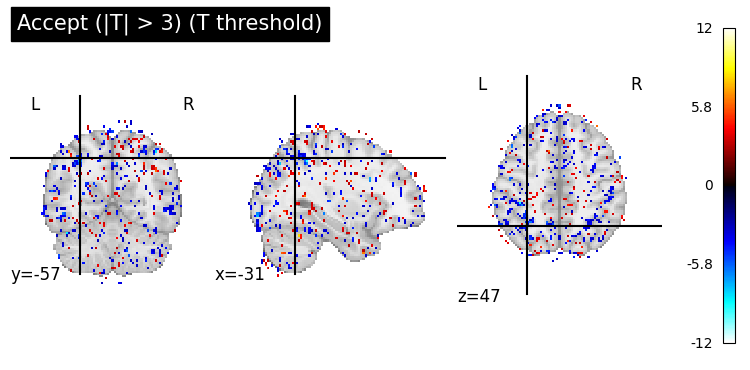

In [179]:
visualize_t_map(anova_results['intensity'], data_importer.original_shape, mask_img, threshold_type="t", threshold_value=3.0, title="Accept (|T| > 3)")

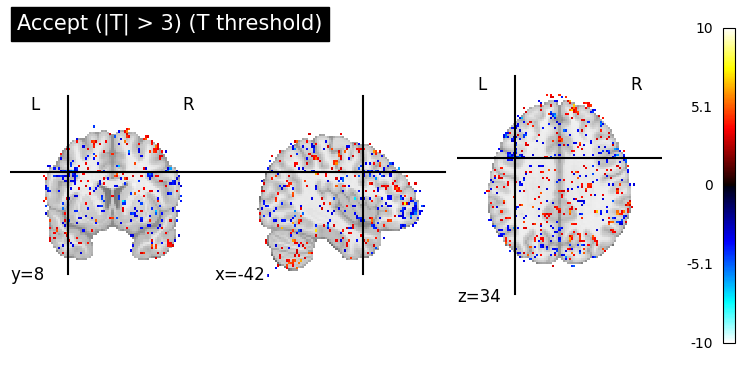

In [180]:
visualize_t_map(anova_results['interaction'], data_importer.original_shape, mask_img, threshold_type="t", threshold_value=3.0, title="Accept (|T| > 3)")

In [222]:
term_subject = MixedEffect(demographics.SUB_ID)
term_subject

In [249]:
n_subjects = 33  # 获取数据后被试的数量
# 创建被试ID（重复效应）
subject_ids = np.tile(np.arange(n_subjects), 4)
subject_ids_str = np.array(subject_ids, dtype=str) 
# 创建强度因子 (0=强, 1=弱)
intensity = np.repeat([0, 0, 1, 1], n_subjects)
# 将强度因子转换为字符串
intensity_str = np.array(intensity, dtype=str)  # 转换为字符串

# 创建决策因子 (0=接受, 1=拒绝)
decision = np.repeat([0, 1, 0, 1], n_subjects)
# 将决策因子转换为字符串
decision_str = np.array(decision, dtype=str)  # 转换为字符串

# 创建设计矩阵 (使用pandas DataFrame，更易于处理)
design = pd.DataFrame({
    'intensity': intensity_str,  # 使用字符串类型的强度
    'decision': decision_str,  # 使用字符串类型的决策
    'subject': subject_ids_str  # 包含 subject ID
})
intensity_effect = FixedEffect(design[['intensity']])
decision_effect = FixedEffect(design[['decision']])
contrasts = {
    'intensity': (design['intensity']=='1').astype(int) - (design['intensity']=='0').astype(int),  # 强度主效应
    'decision': (design['decision']=='1').astype(int) - (design['decision']=='0').astype(int),  # 决策主效应
}
contrasts['interaction'] =  contrasts['intensity'] * contrasts['decision'] # 交互作用
term_subject = MixedEffect(design['subject'],fix= subject_ids)
term_subject

,intercept,x0
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4
...,...,...
127,1,28
128,1,29
129,1,30
130,1,31


,intercept,intensity_0,intensity_1
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0
...,...,...,...
127,1,0,1
128,1,0,1
129,1,0,1
130,1,0,1


In [230]:
demographics

,SUB_ID,VISIT,AGE_AT_SCAN,SEX
0,031404,1,27,F
1,04a144,1,25,M
2,0b78f1,1,33,M
3,0d26b9,1,36,F
4,1988b8,1,31,M
...,...,...,...,...
77,f25714,1,30,F
78,f25714,2,33,F
79,f615a5,1,26,F
80,feac6b,1,26,F
